# TTS Inference Model Selection

This notebook can be used to generate audio samples using either NeMo's pretrained models or after training NeMo TTS models. This notebook supports all TTS models and is intended to showcase different models and how their results differ.

In [1]:
fd = []
mmd = []
models = []

# License

> Copyright 2020 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [2]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# # If you're using Google Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget unidecode
# BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[tts]

'\nYou can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.\nInstructions for setting up Colab are as follows:\n1. Open a new Python 3 notebook.\n2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)\n3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)\n4. Run this cell to set up dependencies.\n'

## Models

First we pick the models that we want to use. Currently supported models are:

End-to-End Models:
- [FastPitch_HifiGan_E2E](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_e2e_fastpitchhifigan)
- [FastSpeech2_HifiGan_E2E](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_e2e_fastspeech2hifigan)

Mel Spectrogram Generators:
- [Tacotron 2](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_tacotron2)
- [Glow-TTS](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_glowtts)
- [TalkNet](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_talknet)
  - <span style="color:red"> NOTE: TalkNet loading is not working in main. Please use r1.2.0 for TalkNet inference </span>
- [FastPitch](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_fastpitch)
- [FastSpeech2](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_fastspeech_2)

Audio Generators
- [WaveGlow](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_waveglow_88m)
- [SqueezeWave](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_squeezewave)
- [UniGlow](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_uniglow)
- [MelGAN](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_melgan)
- [HiFiGAN](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_hifigan)
- Griffin-Lim

In [3]:
from ipywidgets import Select, HBox, Label
from IPython.display import display

supported_e2e = ["fastpitch_hifigan", "fastspeech2_hifigan", None]
# supported_spec_gen = ["tacotron2", "glow_tts", "talknet", "fastpitch", "fastspeech2", None]
supported_spec_gen = ["tacotron2", "glow_tts", "fastpitch", "fastspeech2", None]
supported_audio_gen = ["waveglow", "squeezewave", "uniglow", "melgan", "hifigan", "griffin-lim", None]

print("Select the model(s) that you want to use. Please choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.")
e2e_selector = Select(options=supported_e2e, value=None)
spectrogram_generator_selector = Select(options=supported_spec_gen, value=None)
audio_generator_selector = Select(options=supported_audio_gen, value=None)
display(HBox([e2e_selector, Label("OR"), spectrogram_generator_selector, Label("+"), audio_generator_selector]))

Select the model(s) that you want to use. Please choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.


In [29]:
e2e_model = e2e_selector.value
spectrogram_generator = spectrogram_generator_selector.value
audio_generator = audio_generator_selector.value

if e2e_model is None and spectrogram_generator is None and audio_generator is None:
    raise ValueError("No models were chosen. Please return to the previous step and choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.")

if e2e_model and (spectrogram_generator or audio_generator):
    raise ValueError(
        "An end-to-end model was chosen and either a spectrogram generator or a vocoder was also selected. For end-to-end models, please select `None` "
        "in the second and third column to continue. For the two step pipeline, please select `None` in the first column to continue."
    )

if (spectrogram_generator and audio_generator is None) or (audio_generator and spectrogram_generator is None):
    raise ValueError("In order to continue with the two step pipeline, both the spectrogram generator and the audio generator must be chosen, but one was `None`")
    

## Load model checkpoints

Next we load the pretrained model provided by NeMo. All NeMo models have two functions to help with this

- list_available_models(): This function will return a list of all pretrained checkpoints for that model
- from_pretrained(): This function will download the pretrained checkpoint, load it, and return an instance of the model

Below we will use `from_pretrained` to load the chosen models from above.

In [30]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder, TextToWaveform


def load_spectrogram_model():
    override_conf = None
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        pretrained_model = "tts_en_tacotron2"
    elif spectrogram_generator == "glow_tts":
        from nemo.collections.tts.models import GlowTTSModel
        pretrained_model = "tts_en_glowtts"
        import wget
        from pathlib import Path
        if not Path("cmudict-0.7b").exists():
            filename = wget.download("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b")
            filename = str(Path(filename).resolve())
        else:
            filename = str(Path("cmudict-0.7b").resolve())
        conf = SpectrogramGenerator.from_pretrained(pretrained_model, return_config=True)
        if "params" in conf.parser:
            conf.parser.params.cmu_dict_path = filename
        else:
            conf.parser.cmu_dict_path = filename
        override_conf = conf
    elif spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetSpectModel
        pretrained_model = "tts_en_talknet" 
    elif spectrogram_generator == "fastpitch":
        from nemo.collections.tts.models import FastPitchModel
        pretrained_model = "tts_en_fastpitch"
    elif spectrogram_generator == "fastspeech2":
        from nemo.collections.tts.models import FastSpeech2Model
        pretrained_model = "tts_en_fastspeech2"
    else:
        raise NotImplementedError

    model = SpectrogramGenerator.from_pretrained(pretrained_model, override_config_path=override_conf)
    
    if spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetPitchModel
        pitch_model = TalkNetPitchModel.from_pretrained(pretrained_model, override_config_path=override_conf)
        from nemo.collections.tts.models import TalkNetDursModel
        durs_model = TalkNetDursModel.from_pretrained(pretrained_model, override_config_path=override_conf)
        model.add_module('_pitch_model', pitch_model)
        model.add_module('_durs_model', durs_model)
    
    return model


def load_vocoder_model():
    RequestPseudoInverse = False
    TwoStagesModel = False
    strict=True
    
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "tts_waveglow"
        strict=False
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel
        pretrained_model = "tts_squeezewave"
    elif audio_generator == "uniglow":
        from nemo.collections.tts.models import UniGlowModel
        pretrained_model = "tts_uniglow"
    elif audio_generator == "melgan":
        from nemo.collections.tts.models import MelGanModel
        pretrained_model = "tts_melgan"
    elif audio_generator == "hifigan":
        from nemo.collections.tts.models import HifiGanModel
        pretrained_model = "tts_hifigan"
    elif audio_generator == "griffin-lim":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': 1024, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': 22050, 'n_fft': 1024, 
                                   'mel_fmin': 0, 'mel_fmax': 8000, 'mel_freq': 80}}}
        model = TwoStagesModel(cfg)            
        TwoStagesModel = True
    else:
        raise NotImplementedError

    if not TwoStagesModel:
        model = Vocoder.from_pretrained(pretrained_model, strict=strict)
    return model

def load_e2e_model():
    if e2e_model == "fastpitch_hifigan":
        from nemo.collections.tts.models import FastPitchHifiGanE2EModel
        pretrained_model = "tts_en_e2e_fastpitchhifigan"
    elif e2e_model == "fastspeech2_hifigan":
        from nemo.collections.tts.models import FastSpeech2HifiGanE2EModel
        pretrained_model = "tts_en_e2e_fastspeech2hifigan"
    else:
        raise NotImplementedError

    model = TextToWaveform.from_pretrained(pretrained_model)
    return model

emodel = None
spec_gen = None
vocoder = None
if e2e_model:
    emodel = load_e2e_model().eval().cuda()
else:
    spec_gen = load_spectrogram_model().eval().cuda()
    vocoder = load_vocoder_model().eval().cuda()

[NeMo I 2021-11-06 17:09:48 cloud:56] Found existing object /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_en_fastpitch/9651f9eb32324e98f965b98e94978217/tts_en_fastpitch.nemo.
[NeMo I 2021-11-06 17:09:48 cloud:62] Re-using file from: /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_en_fastpitch/9651f9eb32324e98f965b98e94978217/tts_en_fastpitch.nemo
[NeMo I 2021-11-06 17:09:48 common:702] Instantiating model from pre-trained checkpoint


[NeMo W 2021-11-06 17:09:49 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
    max_duration: null
    min_duration: 0.1
    sample_rate: 22050
    trim: false
    parser: null
    drop_last: true
    shuffle: true
    batch_size: 48
    num_workers: 12
    
[NeMo W 2021-11-06 17:09:49 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_val.json
    max_duration: null
    min_duration: 0.1
    sample_rate: 22050
    trim: false
    parser: null
    drop_last: false
    shuffle: false
    batch_size: 48
    num_workers: 8
   

[NeMo I 2021-11-06 17:09:49 features:262] PADDING: 1
[NeMo I 2021-11-06 17:09:49 features:279] STFT using torch
[NeMo I 2021-11-06 17:09:50 save_restore_connector:143] Model FastPitchModel was successfully restored from /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_en_fastpitch/9651f9eb32324e98f965b98e94978217/tts_en_fastpitch.nemo.
[NeMo I 2021-11-06 17:09:50 cloud:56] Found existing object /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2021-11-06 17:09:50 cloud:62] Re-using file from: /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2021-11-06 17:09:50 common:702] Instantiating model from pre-trained checkpoint


[NeMo W 2021-11-06 17:09:52 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2021-11-06 17:09:52 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2021-11-06 17:09:52 features:262] PADDING: 0
[NeMo I 2021-11-06 17:09:52 features:279] STFT using torch


[NeMo W 2021-11-06 17:09:52 features:240] Using torch_stft is deprecated and will be removed in 1.1.0. Please set stft_conv and stft_exact_pad to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2021-11-06 17:09:52 features:262] PADDING: 0
[NeMo I 2021-11-06 17:09:52 features:279] STFT using torch
[NeMo I 2021-11-06 17:09:52 save_restore_connector:143] Model HifiGanModel was successfully restored from /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [7]:
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import FastPitchModel

last_ckpt = 'fastpitch_exp_manager/FastPitch/2021-11-04_07-04-54/checkpoints/FastPitch--v_loss=0.9107-epoch=29-last.ckpt'
spec_gen = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_gen.eval().cuda()

best_ckpt = 'hifigan_ft/HifiGan/2021-11-06_05-50-16/checkpoints/HifiGan--val_loss=0.3778-epoch=28-last.ckpt'
vocoder = HifiGanModel.load_from_checkpoint(best_ckpt)
vocoder.eval().cuda()

[NeMo W 2021-11-06 16:53:21 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharWithPriorAndPitchDataset
      manifest_filepath: ../../datasets/LJSpeech-1.1/train_manifest.json
      max_duration: null
      min_duration: 0.1
      int_values: false
      normalize: true
      sample_rate: 22050
      trim: false
      sup_data_path: ./Priors_ljspeech
      n_window_stride: 256
      n_window_size: 1024
      pitch_fmin: 80
      pitch_fmax: 640
      pitch_avg: 211.27540199742586
      pitch_std: 52.1851002822779
      vocab:
        notation: phonemes
        punct: true
        spaces: true
        stresses: true
        add_blank_at: None
        pad_with_space: true
        chars: true
        improved_version_g2p: true
    dataloader_params:
      drop_

[NeMo I 2021-11-06 16:53:22 features:262] PADDING: 1
[NeMo I 2021-11-06 16:53:22 features:279] STFT using torch


[NeMo W 2021-11-06 16:53:22 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: ./hifigan_train_ft.json
      max_duration: null
      min_duration: 0.75
      n_segments: 8192
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 4
      num_workers: 4
    
[NeMo W 2021-11-06 16:53:22 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: ./hifigan_val_ft.json
      max_duration: null
      min_d

[NeMo I 2021-11-06 16:53:22 features:262] PADDING: 0
[NeMo I 2021-11-06 16:53:22 features:279] STFT using torch
[NeMo I 2021-11-06 16:53:22 features:281] STFT using exact pad
[NeMo I 2021-11-06 16:53:22 features:262] PADDING: 0
[NeMo I 2021-11-06 16:53:22 features:279] STFT using torch
[NeMo I 2021-11-06 16:53:22 features:281] STFT using exact pad


HifiGanModel(
  (audio_to_melspec_precessor): FilterbankFeatures()
  (trg_melspec_fn): FilterbankFeatures()
  (generator): Generator(
    (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
    (ups): ModuleList(
      (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
      (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
      (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
      (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    )
    (resblocks): ModuleList(
      (0): ModuleList(
        (0): ResBlock1(
          (convs1): ModuleList(
            (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
            (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
          )
          (convs2): ModuleList(
            (0

## Inference

Now that we have downloaded the model checkpoints and loaded them into memory. Let's define a short infer helper function that takes a string, and our models to produce speech.

Notice that the NeMo TTS model interface is fairly simple and standardized across all models.

End-to-end models have two helper functions:
- parse(): Accepts raw python strings and returns a torch.tensor that represents tokenized text
- convert_text_to_waveform(): Accepts a batch of tokenized text and returns a torch.tensor that represents a batch of raw audio

Mel Spectrogram generators have two helper functions:

- parse(): Accepts raw python strings and returns a torch.tensor that represents tokenized text
- generate_spectrogram(): Accepts a batch of tokenized text and returns a torch.tensor that represents a batch of spectrograms

Vocoder have just one helper function:

- convert_spectrogram_to_audio(): Accepts a batch of spectrograms and returns a torch.tensor that represents a batch of raw audio

In [31]:
def infer(emodel, spec_gen_model, vocder_model, str_input):
    parser_model = emodel or spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        if emodel is None:
            spectrogram = spec_gen.generate_spectrogram(tokens=parsed)
            audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
        else:
            spectrogram = None
            audio = emodel.convert_text_to_waveform(tokens=parsed)[0]
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [32]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

text = 'My name is Trina. Above all things, I am a horror fan. And while the year 2020 feels like a well-crafted movie or'
spec, audio = infer(emodel, spec_gen, vocoder, text)

ipd.Audio(audio, rate=22050)

Now that everything is set up, let's give an input that we want our models to speak

In [33]:
import pandas as pd

metadata = pd.read_csv('../../datasets/LJSpeech-1.1/metadata_test.csv', index_col=0)
metadata.head()

,file_name,transcript,normalized
4347,LJ015-0247,"at that station the safes were given out, heav...","At that station the safes were given out, heav..."
7732,LJ028-0475,no traces of its moat have appeared.,No traces of its moat have appeared.
3545,LJ013-0049,"a notorious miser, robert smith, had recently ...","A notorious miser, Robert Smith, had recently ..."
1237,LJ005-0119,no attempt was made to maintain discipline.,No attempt was made to maintain discipline.
720,LJ003-0198,few realizing that the dreadful fate would ove...,Few realizing that the dreadful fate would ove...


In [34]:
ids = metadata['file_name'].values
texts = metadata['file_name'].values

In [35]:
from scipy.io.wavfile import write
from tqdm import tqdm
import shutil

samplerate = 22050

for i in tqdm(range(len(ids[:50]))):
    filename = ids[i]
    text = texts[i]
    spec, audio = infer(emodel, spec_gen, vocoder, text)

# audio = np.ushort(audio * 65535)
# print(audio)
# ipd.Audio(audio, rate=samplerate)
    write(f"./gw/{filename}.wav", samplerate, audio.reshape(-1, 1))
    shutil.copyfile(f'../../datasets/LJSpeech-1.1/wavs/{filename}.wav', f"./w/{filename}.wav")

100%|██████████| 50/50 [00:02<00:00, 21.17it/s]


In [36]:
from speech_distances.speech_distances import FrechetDistance, MMD

path = "./gw" # path to .wav files to be evaluated
# reference_path = "../LJSpeech-1.1/wavs" # path to reference .wav files
reference_path = "./w" # path to reference .wav files

backbone = "deepspeech2" # name of neural network to be used as feature extractor 
                         # available backbones: "deepspeech2", "wav2vec2", "quartznet",
                         # "speakerrecognition_speakernet", "speakerverification_speakernet"
          
sr = 22050 # sampling rate of these audio files
           # audio will be resampled to sampling rate suitable for the particular backbone, typically 16000
           
sample_size = 25 # number of wav files to be sampled from provided directories and used for evaluation
num_runs = 3 # number of runs with different subsets of files for computation of mean and std

window_size = 320 # number of timesteps within one window for feature computation
                   # for all windows the features are computed independently and then averaged 
                   # if None use maximum window size and average only resulting feature maps
                   
conditional = True # defines whether to compute conditional version of the distance of not
use_cached = True # try to reuse extracted features if possible?

FD = FrechetDistance(path=path, reference_path=reference_path, backbone=backbone,
                     sr=sr, sample_size=sample_size,
                     num_runs=num_runs, window_size=window_size,
                     conditional=conditional, use_cached=use_cached)
                     
fd_result = FD.calculate_metric() # outputs mean and std of metric computed for different subsets (num_runs) of audio files 
fd.append(fd_result)

MMD_ = MMD(path=path, reference_path=reference_path, backbone=backbone,
                     sr=sr, sample_size=sample_size,
                     num_runs=num_runs, window_size=window_size,
                     conditional=conditional, use_cached=use_cached)
                     
mmd_result = MMD_.calculate_metric() # outputs mean and std of metric computed for different subsets (num_runs) of audio files
mmd.append(mmd_result)

[NeMo W 2021-11-06 17:10:12 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/scipy/linalg/_matfuncs_sqrtm.py:191: RuntimeWarning: invalid value encountered in double_scalars
      arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')
    


In [37]:
models.append('fastpitch_hifigan') #uniglow, melgan, hifigan

In [38]:
mmd

[(tensor(2.9405e-05), tensor(7.6641e-07)),
 (tensor(2.6782e-05), tensor(6.0001e-07))]

In [163]:
models

['fastpitch_hifigan',
 'tacotron2_waveglow',
 'tacotron2_squeezewave',
 'tacotron2_uniglow',
 'tacotron2_melgan',
 'glow_tts_waveglow',
 'glow_tts_squeezewave',
 'glow_tts_uniglow',
 'glow_tts_melgan',
 'tacotron2_hifigan',
 'glow_tts_hifigan',
 'fastpitch_waveglow',
 'fastpitch_squeezewave',
 'fastpitch_uniglow',
 'fastpitch_melgan',
 'fastpitch_hifigan']

In [50]:
mmd

[(tensor(2.9405e-05), tensor(7.6641e-07)),
 (tensor(2.6782e-05), tensor(6.0001e-07))]

In [52]:
result = pd.DataFrame(columns=['model', 'mmd_mean', 'mmd_std', 'fd_mean', 'fd_std'])

result['model'] = models

result['mmd_mean'] = torch.tensor(mmd)[:,0]
result['mmd_std'] = torch.tensor(mmd)[:,1]
result['fd_mean'] = torch.tensor(fd)[:,0]
result['fd_std'] = torch.tensor(fd)[:,1]

result

,model,mmd_mean,mmd_std,fd_mean,fd_std
0,fastpitch_hifigan_trained,0.000029,7.664085e-07,0.010102,0.000362
1,fastpitch_hifigan,0.000027,6.000070e-07,0.009854,0.000416


In [53]:
result.to_csv('models_results.csv')

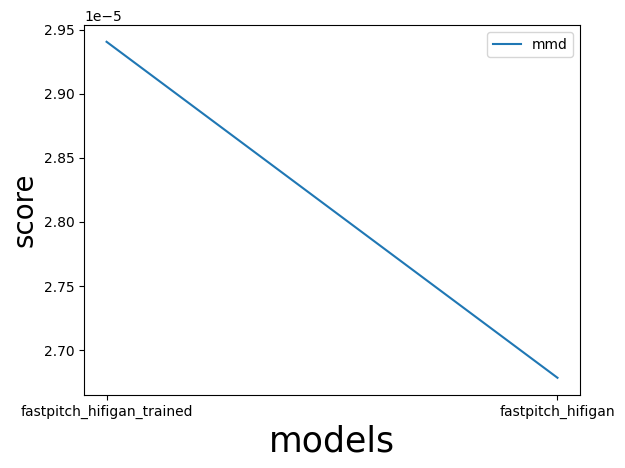

In [56]:
from matplotlib import pyplot as plt

# plt.figure(figsize=(32, 12))

plt.plot(result['model'], result['mmd_mean'], label='mmd')
# plt.plot(result['model'], result['fd_mean'] , label='fd')

leg = plt.legend()

plt.xlabel('models', fontsize=25)
plt.ylabel('score', fontsize=20)

plt.show()

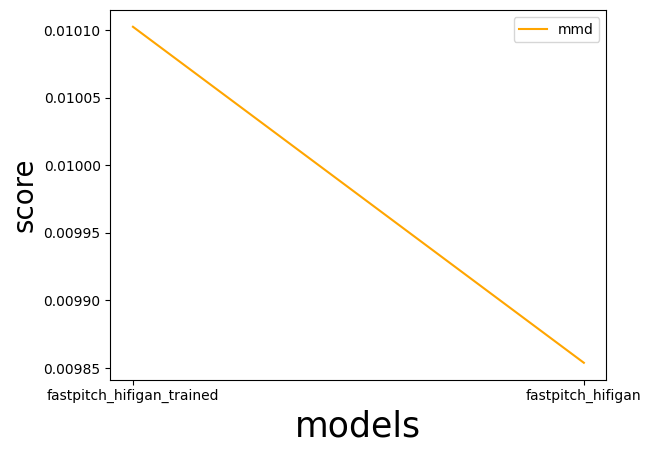

In [58]:
from matplotlib import pyplot as plt

# plt.figure(figsize=(32, 12))

plt.plot(result['model'], result['fd_mean'], label='mmd', color='orange')
# plt.plot(result['model'], result['fd_mean'] , label='fd')

leg = plt.legend()

plt.xlabel('models', fontsize=25)
plt.ylabel('score', fontsize=20)

plt.show()

In [46]:
# fastpitch, griffith
# ((tensor(0.0001, dtype=torch.float64), tensor(nan, dtype=torch.float64)),
# (tensor(4.7684e-07), tensor(nan)))

((tensor(0.0001, dtype=torch.float64), tensor(nan, dtype=torch.float64)),
 (tensor(4.7684e-07), tensor(nan)))

In [23]:
# fastpitch, uniglow
# ((tensor(0.0001, dtype=torch.float64),  tensor(4.9905e-10, dtype=torch.float64)),
# (tensor(3.5763e-07), tensor(1.6859e-07)))

((tensor(0.0001, dtype=torch.float64),
  tensor(4.9905e-10, dtype=torch.float64)),
 (tensor(3.5763e-07), tensor(1.6859e-07)))

In [11]:
# glowtts, squeezwave
#((tensor(0.0001, dtype=torch.float64),  tensor(1.8522e-10, dtype=torch.float64)),
# (tensor(4.7684e-07), tensor(0.)))

In [10]:
# tacotron2 + waveglow
# ((tensor(0.0001, dtype=torch.float64), tensor(nan, dtype=torch.float64)),
# (tensor(2.3842e-07), tensor(nan)))

In [ ]:
# fastpitch_hifigan
# ((tensor(0.0001, dtype=torch.float64), tensor(nan, dtype=torch.float64)),
# (tensor(4.7684e-07), tensor(nan)))

# Results

After our model generates the audio, let's go ahead and play it. We can also visualize the spectrogram that was produced from the first stage model if a spectrogram generator was used.

In [30]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

text = 'Привет, как дела'
spec, audio = infer(emodel, spec_gen, vocoder, text)

ipd.Audio(audio, rate=22050)

[NeMo W 2021-10-22 01:32:28 patch_utils:50] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-10-22 01:32:28 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
      normalized, onesided, return_complex)
    
[NeMo W 2021-10-22 01:32:28 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered i

In [232]:
audio = audio.T

In [243]:
gt.shape, audio.shape

((212893,), (188928, 1))

In [221]:
from scipy.io import wavfile
samplerate, gt = wavfile.read('../LJSpeech-1.1/wavs/LJ001-0001.wav')


In [222]:
gt

array([-24, -25, -21, ...,  24,   7,   2], dtype=int16)

In [205]:
from scipy.io.wavfile import write

samplerate = 22050; fs = 100
t = np.linspace(0., 1., samplerate)
amplitude = np.iinfo(np.int16).max
data = amplitude * np.sin(2. * np.pi * fs * t)
write("example.wav", samplerate, data.astype(np.int16))

In [9]:
%matplotlib inline
if spec is not None:
    imshow(spec, origin="lower")
    plt.show()

In [10]:
from nemo.collections.tts.models import TalkNetSpectModel, TalkNetPitchModel, TalkNetDursModel

pretrained_model = "tts_en_talknet"
model = TalkNetSpectModel.from_pretrained(pretrained_model)
model.add_module('_pitch_model', TalkNetPitchModel.from_pretrained(pretrained_model))
model.add_module('_durs_model', TalkNetDursModel.from_pretrained(pretrained_model))

FileNotFoundError: Model tts_en_talknet was not found. Check cls.list_available_models() for the list of all available models.

In [ ]:
import nemo_asr

In [11]:
# Load spectrogram generator
from nemo.collections.tts.models import FastPitchModel
spec_generator = FastPitchModel.from_pretrained("tts_en_fastpitch")

# Load WaveGlow
from nemo.collections.tts.models import WaveGlowModel
vocoder = WaveGlowModel.from_pretrained(model_name="tts_waveglow_88m")

# Generate audio
import soundfile as sf
parsed = spec_generator.parse("You can type your sentence here to get nemo to produce speech.")
spectrogram = spec_generator.generate_spectrogram(tokens=parsed)
audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

# Save the audio to disk in a file called speech.wav
# sf.write("speech.wav", audio.to('cpu').numpy(), 22050)

[NeMo I 2021-10-20 11:48:09 cloud:56] Found existing object /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_en_fastpitch/9651f9eb32324e98f965b98e94978217/tts_en_fastpitch.nemo.
[NeMo I 2021-10-20 11:48:09 cloud:62] Re-using file from: /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_en_fastpitch/9651f9eb32324e98f965b98e94978217/tts_en_fastpitch.nemo
[NeMo I 2021-10-20 11:48:09 common:702] Instantiating model from pre-trained checkpoint


[NeMo W 2021-10-20 11:48:10 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
    max_duration: null
    min_duration: 0.1
    sample_rate: 22050
    trim: false
    parser: null
    drop_last: true
    shuffle: true
    batch_size: 48
    num_workers: 12
    
[NeMo W 2021-10-20 11:48:10 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_val.json
    max_duration: null
    min_duration: 0.1
    sample_rate: 22050
    trim: false
    parser: null
    drop_last: false
    shuffle: false
    batch_size: 48
    num_workers: 8
   

[NeMo I 2021-10-20 11:48:10 features:262] PADDING: 1
[NeMo I 2021-10-20 11:48:10 features:279] STFT using torch
[NeMo I 2021-10-20 11:48:11 save_restore_connector:143] Model FastPitchModel was successfully restored from /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_en_fastpitch/9651f9eb32324e98f965b98e94978217/tts_en_fastpitch.nemo.
[NeMo I 2021-10-20 11:48:11 cloud:56] Found existing object /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo.
[NeMo I 2021-10-20 11:48:11 cloud:62] Re-using file from: /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo
[NeMo I 2021-10-20 11:48:11 common:702] Instantiating model from pre-trained checkpoint


[NeMo W 2021-10-20 11:48:13 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      n_segments: 16000
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 12
      num_workers: 4
    
[NeMo W 2021-10-20 11:48:13 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_val.json

[NeMo I 2021-10-20 11:48:13 features:262] PADDING: 16
[NeMo I 2021-10-20 11:48:13 features:279] STFT using torch
[NeMo I 2021-10-20 11:48:13 save_restore_connector:143] Model WaveGlowModel was successfully restored from /home/boris/.cache/torch/NeMo/NeMo_1.4.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo.


[NeMo W 2021-10-20 11:48:14 patch_utils:50] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-10-20 11:48:14 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
      normalized, onesided, return_complex)
    
[NeMo W 2021-10-20 11:48:14 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered i

In [12]:
ipd.Audio(audio.to('cpu').numpy(), rate=22050)